# Estadística inferencial no paramétrica: Kruskal–Wallis

- Alternativa no paramétrica a ANOVA de 1 vía (k ≥ 3 grupos, muestras **independientes**).
- H₀: todas las poblaciones tienen la **misma distribución** (medianas similares).
- Si se rechaza H₀, se recomienda **post-hoc de Dunn** con corrección por comparaciones múltiples.


In [1]:
def import_csv(file):
    import pandas as pd
    return pd.read_csv(file)

path = "../data/Terminos_lagoon_TA_DIC_2023_RawData.csv"
co2_data = import_csv(path)

co2_data.head()


,sample,date,estuary,area,station,layer_depth,season,chlorophy_microg_l,cond_microsiemens_cm,depth_m,...,do_mg_l,sal_psu,sp_cond_microsiemens_cm,turbidity_fnu,temp_c,latitude,longitude,dic_micromol_kg,ta_micromol_kg,dummy_data
0,CDL01S,5/3/2020,Candelaria,River,CDL01,Surface,Dry,0.36,7015.4,0.464,...,7.12,3.56,6547.7,1.47,28.740,18.55736,-91.25012,3915,3863,3685.0
1,CDL01F,5/3/2020,Candelaria,River,CDL01,Bottom,Dry,4.19,29886.1,7.792,...,4.90,16.97,27751.2,95.33,29.028,18.55722,-91.24990,3698,3685,NaN
2,CDL02S,5/3/2020,Candelaria,River,CDL02,Surface,Dry,0.92,16691.1,0.453,...,6.99,8.94,15429.1,5.50,29.283,18.61007,-91.24410,3724,3708,3708.0
3,CDL02F,5/3/2020,Candelaria,River,CDL02,Bottom,Dry,2.23,24847.4,1.261,...,6.52,13.87,23074.0,13.44,29.024,18.61005,-91.24403,3667,3992,3992.0
4,CDL03S,5/3/2020,Candelaria,River,CDL03,Surface,Dry,0.58,46341.6,0.465,...,6.24,28.06,43670.8,3.60,28.202,18.63166,-91.29359,2928,3023,3023.0


In [3]:
from scipy.stats import kruskal

def kruskal_wallis_test(*groups, alpha=0.05, label=""):
    """
    Kruskal–Wallis para k grupos independientes.
    Acepta series/arrays como *groups.
    """
    clean = [g.dropna() for g in groups]
    res = kruskal(*clean)
    print(f"[{label}] H = {res.statistic:.4f}, p = {res.pvalue:.6f}")
    if res.pvalue < alpha:
        print("→ Diferencias **significativas** entre grupos (rechazamos H₀)")
    else:
        print("→ No hay diferencias significativas (no rechazamos H₀)")


In [4]:
# --- Seleccionar los grupos de TA por área ---
ta_river = co2_data.loc[co2_data["area"] == "River", "ta_micromol_kg"].dropna()
ta_plume = co2_data.loc[co2_data["area"] == "Plume", "ta_micromol_kg"].dropna()
ta_coast = co2_data.loc[co2_data["area"] == "Coast", "ta_micromol_kg"].dropna()

# --- Revisar que los grupos tienen datos ---
print("n River:", len(ta_river))
print("n Plume:", len(ta_plume))
print("n Coast:", len(ta_coast))

# --- Llamar a la función Kruskal-Wallis ---
kruskal_wallis_test(ta_river, ta_plume, ta_coast, label="TA ~ area")


n River: 35
n Plume: 35
n Coast: 36
[TA ~ area] H = 23.3407, p = 0.000009
→ Diferencias **significativas** entre grupos (rechazamos H₀)


In [7]:
try:
    import scikit_posthocs as sp
    def dunn_posthoc(data, group_col, value_col, p_adjust='bonferroni'):
        """
        Dunn post-hoc tras Kruskal–Wallis.
        Regresa una matriz de p-valores ajustados.
        """
        out = sp.posthoc_dunn(data, val_col=value_col, group_col=group_col, p_adjust=p_adjust)
        return out
    has_dunn = True
except Exception as e:
    print("scikit-posthocs no está instalado. Omite Dunn o instálalo con conda/pip.")
    has_dunn = False


In [9]:
dunn_ta = dunn_posthoc(co2_data, "area", "ta_micromol_kg")
display(dunn_ta)


,Coast,Plume,River
Coast,1.000000,1.000000,0.000016
Plume,1.000000,1.000000,0.000659
River,0.000016,0.000659,1.000000


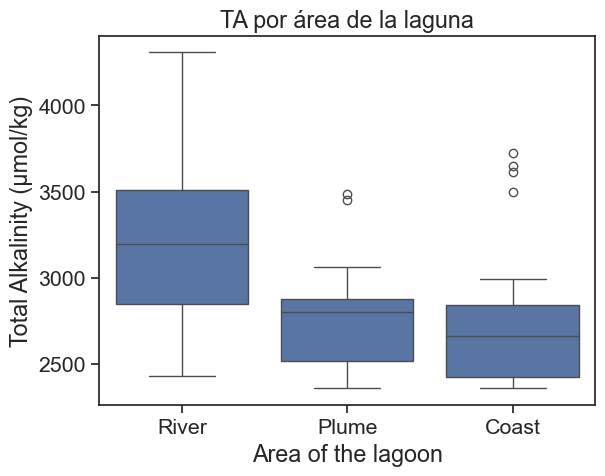

[TA ~ area] H = 23.3407, p = 0.000009
→ Diferencias **significativas** entre grupos (rechazamos H₀)
Dunn post-hoc (TA ~ area) p-ajustados (Bonferroni):


,Coast,Plume,River
Coast,1.000000,1.000000,0.000016
Plume,1.000000,1.000000,0.000659
River,0.000016,0.000659,1.000000


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks", font_scale=1.4)

# Boxplot TA por área
ax = sns.boxplot(x="area", y="ta_micromol_kg", data=co2_data)
plt.xlabel("Area of the lagoon")
plt.ylabel("Total Alkalinity (μmol/kg)")
plt.title("TA por área de la laguna")
sns.despine(top=False, right=False)
plt.show()

# Grupos
ta_river = co2_data.loc[co2_data["area"] == "River", "ta_micromol_kg"]
ta_plume = co2_data.loc[co2_data["area"] == "Plume", "ta_micromol_kg"]
ta_coast = co2_data.loc[co2_data["area"] == "Coast", "ta_micromol_kg"]

# Kruskal–Wallis
kruskal_wallis_test(ta_river, ta_plume, ta_coast, label="TA ~ area")

# Dunn post-hoc (si disponible)
if has_dunn:
    dunn_ta = dunn_posthoc(co2_data, "area", "ta_micromol_kg")
    print("Dunn post-hoc (TA ~ area) p-ajustados (Bonferroni):")
    display(dunn_ta)


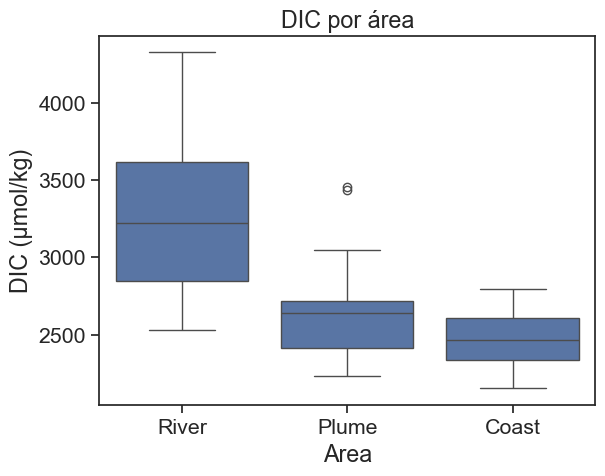

[DIC ~ area] H = 55.8897, p = 0.000000
→ Diferencias **significativas** entre grupos (rechazamos H₀)
Dunn post-hoc (DIC ~ area):


,Coast,Plume,River
Coast,1.000000e+00,0.063144,7.204720e-13
Plume,6.314392e-02,1.000000,1.885873e-06
River,7.204720e-13,0.000002,1.000000e+00


In [11]:
# Boxplot DIC por área
ax = sns.boxplot(x="area", y="dic_micromol_kg", data=co2_data)
plt.xlabel("Area")
plt.ylabel("DIC (μmol/kg)")
plt.title("DIC por área")
sns.despine(top=False, right=False)
plt.show()

# Grupos
dic_river = co2_data.loc[co2_data["area"] == "River", "dic_micromol_kg"]
dic_plume = co2_data.loc[co2_data["area"] == "Plume", "dic_micromol_kg"]
dic_coast = co2_data.loc[co2_data["area"] == "Coast", "dic_micromol_kg"]

# Kruskal–Wallis
kruskal_wallis_test(dic_river, dic_plume, dic_coast, label="DIC ~ area")

# Dunn post-hoc (si disponible)
if has_dunn:
    dunn_dic = dunn_posthoc(co2_data, "area", "dic_micromol_kg")
    print("Dunn post-hoc (DIC ~ area):")
    display(dunn_dic)


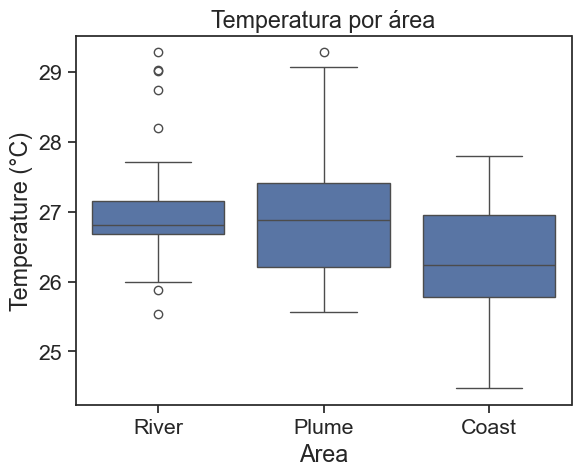

[Temp ~ area] H = 7.6996, p = 0.021284
→ Diferencias **significativas** entre grupos (rechazamos H₀)
Dunn post-hoc (Temp ~ area):


,Coast,Plume,River
Coast,1.000000,0.06468,0.038761
Plume,0.064680,1.00000,1.000000
River,0.038761,1.00000,1.000000


In [12]:
if "temp_c" in co2_data.columns:
    # Boxplot Temp por área
    ax = sns.boxplot(x="area", y="temp_c", data=co2_data)
    plt.xlabel("Area")
    plt.ylabel("Temperature (°C)")
    plt.title("Temperatura por área")
    sns.despine(top=False, right=False)
    plt.show()

    # Grupos
    t_river = co2_data.loc[co2_data["area"] == "River", "temp_c"]
    t_plume = co2_data.loc[co2_data["area"] == "Plume", "temp_c"]
    t_coast = co2_data.loc[co2_data["area"] == "Coast", "temp_c"]

    # Kruskal–Wallis
    kruskal_wallis_test(t_river, t_plume, t_coast, label="Temp ~ area")

    # Dunn post-hoc (si disponible)
    if has_dunn:
        dunn_temp = dunn_posthoc(co2_data, "area", "temp_c")
        print("Dunn post-hoc (Temp ~ area):")
        display(dunn_temp)
else:
    print("No existe la columna 'temp_c' en el dataset.")
